# Time to get your hands dirty! The transient Universe

## Tasks

1. Read in `solutions/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoscedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2. One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$$
y = b, \quad \text{for } t < t_0
$$

$$
y = b + A \exp[-\alpha (t - t_0)], \quad \text{for } t \geq t_0
$$

where \( b \) is the background amplitude, \( A \) is the burst amplitude, \($t_0$) is the burst epoch, and \($\alpha$) encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model.  
*Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now \( x \) is time, and the polynomial model is now the burst model.*

3. Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of: 
$$
\{b, A, t_0, \alpha\}
$$

You must decide on how many samples are appropriate for running your MCMC.  
For your priors, make them

$$
b \in \text{Uniform}[0, 50], \quad A \in \text{Uniform}[0, 50], \quad t_0 \in \text{Uniform}[0, 100], \quad \ln \alpha \in \text{Uniform}[-5, 5]
$$

(careful: uniform in \( $\ln(\alpha)$), not \( $\alpha$))



4. Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5. Make a corner plot of the 4-D parameter space, with labels, [68, 95]% credible levels and quantiles, and titles.

6. Now choose **100** samples randomly from your burned, thinned chain and plot the **100** corresponding burst time-series on a figure along with the original data. You may want to choose a transparent linestyle for these 100 burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7. For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance,

$$
t_0 = X^{+Y}_{-Z}
$$


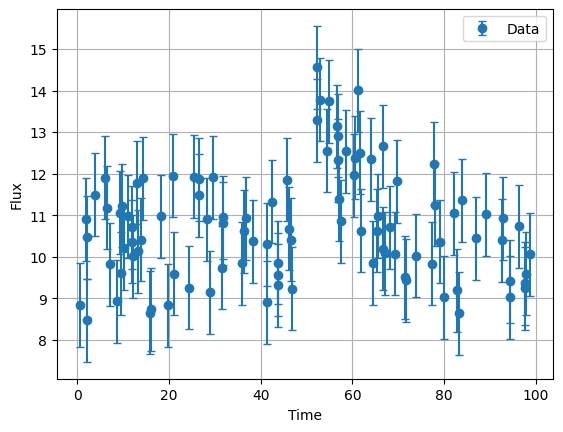

In [1]:
import numpy as np
from matplotlib import pyplot as plt

data = np.load("transient.npy")

time_data, flux, err = data[:,0], data[:,1], data[:,2]

plt.errorbar(time_data, flux, yerr=err, fmt='o', label='Data', capsize=3)
plt.xlabel("Time")
plt.ylabel("Flux")
plt.grid()
plt.legend()
plt.show()

In [ ]:
def model(t, theta ):
    C, A, alpha, t0 = theta
    return np.where(t < t0,                                     # for t < t0
                    C,                                          # costant
                    C + A * np.exp(- alpha *(t - t0)))          # else , exp  function 


def loglikelihood (f , y , sigma): # f is the function, y is the data, sigma is the error
    L = 1
    for i in range(len(flux)):
        L *= (1/(np.sqrt(2*np.pi) * sigma)) * np.exp(-((f[i]-y[i])/(np.sqrt(2)*sigma))**2)
    return np.log(L)


#This represents your belief about the parameters before seeing any data.
def log_prior(theta): 
    C, A, alpha, t0 = theta
    if 0 < C < 50 and 0 < A < 50 and np.exp(-5) < alpha < np.exp(5) and 0 < t0 < 100:   #task boundaries
        return np.log(1 / (50 * 50 * 100 * 10 * alpha ))    # uniform prior, I assume that all values are equally likely within the boundaries
    return -np.inf      # invalid region, if I am out of the true region , prob = 0 , cioè - inf in log


def log_posterior(theta, time_data , flux , err ):
    lp = log_prior(theta)
    if not np.isfinite(lp): #isfinite = true only if it's a finite number
        return -np.inf
    return lp + loglikelihood(flux, model(time_data, theta), err[1])

#I define the likelihood of my model, which is P(data|theta), I define what I know about the data a priori, P(theta), and I also define the posterior function, P(theta|data).
#Now, for Bayesian statistics: the posterior is proportional to the likelihood times the knowledge; if I take the logarithm, it becomes that the posterior is log_likelihood + log_knowledge.


# initial values 
C0 = np.median(flux)
A0 = np.max(flux) - C0
alpha0 = 0.1    #by heart
t0_init = time_data[np.argmax(flux)]

In [3]:
import emcee

ndim = 4                      # number of parameters
nwalkers = 10                 # number of walkers ( 2×ndim or more)
nsteps = 80000                # number of steps per walker

# Initial positions for each walker, scattered around the initial guess
initial = np.array([C0, A0, alpha0, t0_init])
pos = initial + 1e-2 * np.random.randn(nwalkers, ndim) #this create a 8 X 4 matrix of initial guess randomly around guessing

# Set up sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(time_data, flux, err))

# Run MCMC
sampler.run_mcmc(pos, nsteps, progress=True)


  1%|          | 786/80000 [00:09<14:28, 91.19it/s] /tmp/ipykernel_6450/3116835796.py:12: RuntimeWarning: divide by zero encountered in log
  return np.log(L)
100%|██████████| 80000/80000 [18:01<00:00, 73.99it/s] 


State([[10.37352914  7.81314887  0.1376262  48.34448501]
 [10.36003217  4.16270672  0.13195622 51.44072758]
 [10.38422188  4.43167471  0.11698121 51.31104123]
 [10.42358967  4.02918802  0.10527394 50.5990906 ]
 [10.2269366   5.85714387  0.16015269 50.86599505]
 [10.34195345  4.39679214  0.09872044 48.8819069 ]
 [10.02195257  4.48567395  0.11622386 51.49829661]
 [10.24013525  6.43583976  0.11303627 47.89437452]
 [10.33637734  4.5073179   0.11856267 50.04923079]
 [10.33868207  4.26700069  0.11895874 52.16631167]], log_prob=[-155.34667323 -153.58368164 -154.16292543 -154.30511955 -155.63818915
 -153.98995147 -155.93554736 -153.36662941 -153.49186502 -154.35152523], blobs=None, random_state=('MT19937', array([3150724706, 2712715517, 2589087055,  303379958, 3948849933,
       3042933175,  676619624, 1637622195, 1219534147, 3951241888,
       4161635404, 3100592711, 1927161123, 3805553766, 1837830097,
        139216138, 1289960951, 4256942448, 2207162826,   69283071,
       2858426898, 21575

autocorrelation time:  [67.50085443 90.79198592 73.98780078 90.37849917]
Parameters with deviations at the 5th and 95th percentiles for a 90% confidence interval.
$C$ = 10.295 (+0.201/-0.200)
$A$ = 5.397 (+3.407/-1.785)
$\alpha$ = 0.122 (+0.053/-0.036)
$t_0$ = 49.112 (+2.728/-2.048)


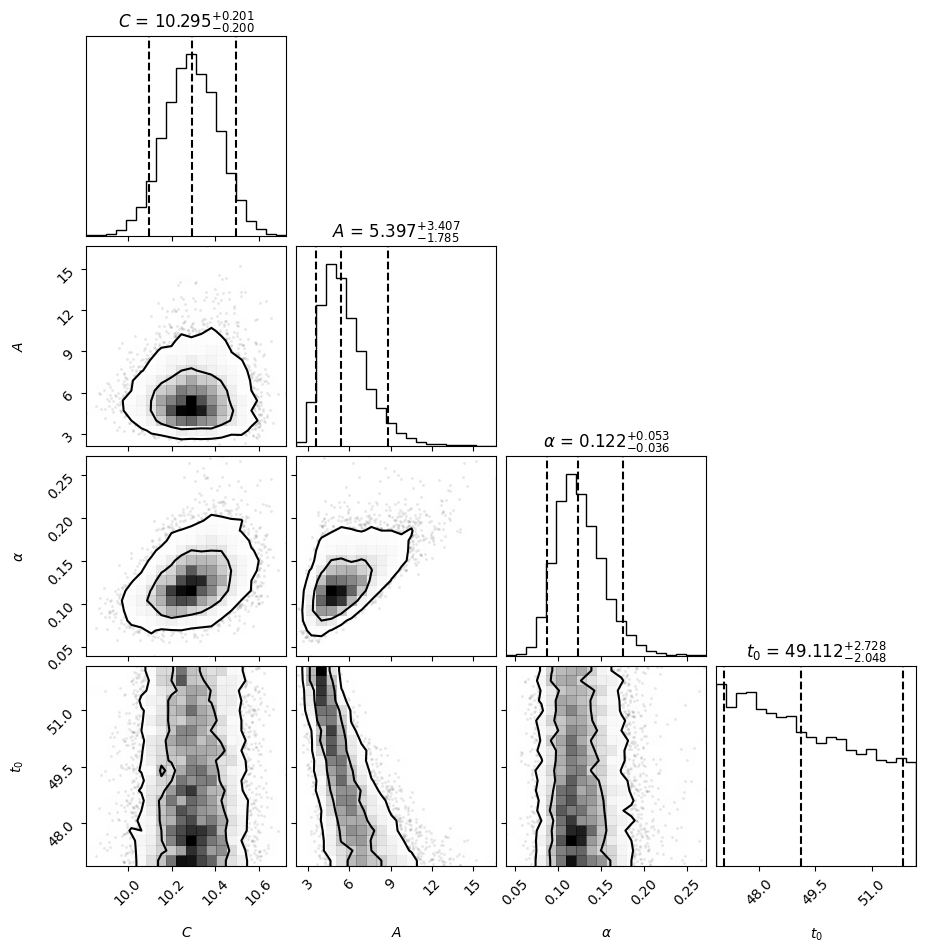

In [4]:
import corner

burn = 5000

# calculate the autocorreletion lenght
autocor_time_data = sampler.get_autocorr_time()
print ("autocorrelation time: ", autocor_time_data) # one for each chain
thin = int(np.mean(autocor_time_data)) #save only the non - correleted samples

# flat of the samples + thinning + burn
flat_samples = sampler.get_chain(discard=burn, thin=thin, flat=True) 

# make it flat means that i take all the samples and put them in a single array, so I have a 1D array of all the samples

labels = [r"$C$", r"$A$", r"$\alpha$", r"$t_0$"]

# Corner plot with confidence levels 
fig_corner = corner.corner(flat_samples, labels=labels, levels=[0.68, 0.95], 
                           show_titles=True, quantiles=[0.05, 0.5, 0.95], 
                           title_fmt=".3f", title_kwargs={"fontsize": 12})

print(" \n\n Parameters with deviations at the 5th and 95th percentiles for a 90% confidence interval.")

for i in range(flat_samples.shape[1]):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    print(f"{labels[i]} = {mcmc[1]:.3f} (+{q[1]:.3f}/-{q[0]:.3f})")

### **Interpreting Joint Distributions in Corner Plots**

When analyzing MCMC results using a corner plot, the **shape and orientation** of the joint distributions between parameters give valuable information about uncertainties and correlations.

####  Case 1: Rectangular shape aligned with axes

If the joint distribution between two parameters appears as a **vertical rectangle**, with:
- the **short side along the x-axis**
- and the **long side along the y-axis**

then:

- The parameter on the **x-axis** is **well constrained** (low uncertainty).
- The parameter on the **y-axis** is **poorly constrained** (high uncertainty).
- There is **no significant correlation** between the two parameters — the distribution is aligned with the axes.

This means that changes in one parameter do **not** require changes in the other to maintain a good fit to the data.

####  Case 2: Tilted (elliptical) shape

If the joint distribution is **tilted** (elliptical and not aligned with the axes), this indicates that the two parameters are **correlated**:

- A **positive correlation** if the ellipse is tilted bottom-left to top-right.
- A **negative correlation** if the ellipse is tilted top-left to bottom-right.

In such cases, a change in one parameter can be compensated by a change in the other to produce a similar model outcome — a typical example is when two parameters interact in the same term of a model function.

####  Case 3: Circular shape

If the joint distribution is **circular**, the parameters are:
- **Independent**
- And have **similar uncertainties**

This typically means the parameters are well-behaved and their effects are distinguishable in the model.



Text(0.5, 0, 'step number')

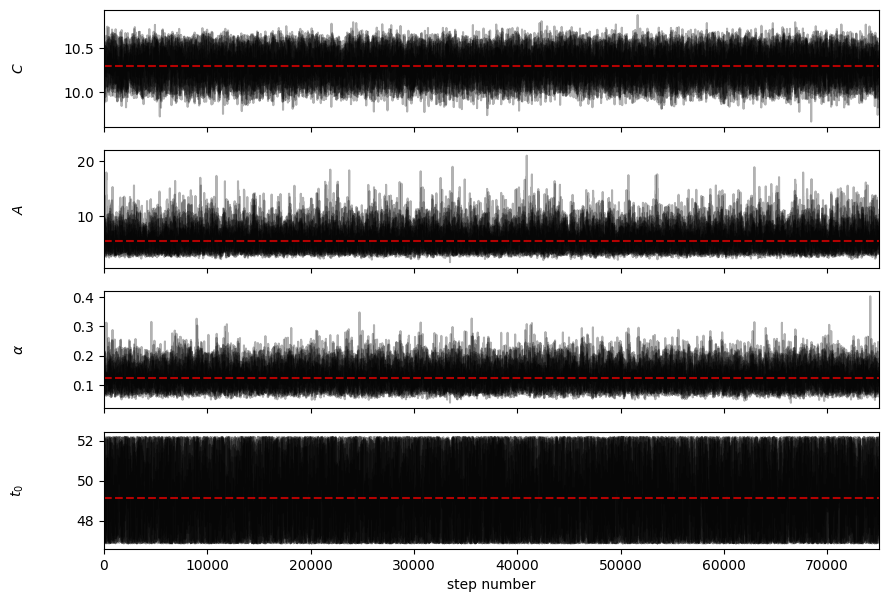

In [5]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=burn) #have I burn it 2 times? No. each time I remove the fist burn, it is not cumulative

labels = [r"$C$", r"$A$", r"$\alpha$", r"$t_0$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)   # for each parameter I plot the evolution of all the walkers
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    median = np.median(flat_samples[:, i])
    ax.axhline(median, color="red", linestyle="--", alpha=0.7) #median of the samples
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")


=== Parameter comparison (with uncertainties) ===
emcee:      C = 10.297 ± 0.122
            A = 5.395 ± 1.559
        alpha = 0.123 ± 0.027
           t0 = 49.130 ± 1.786

curve_fit:  C = 10.298 ± 0.126
            A = 3.707 ± 0.602
        alpha = 0.117 ± 0.031
           t0 = 52.185 ± 0.000


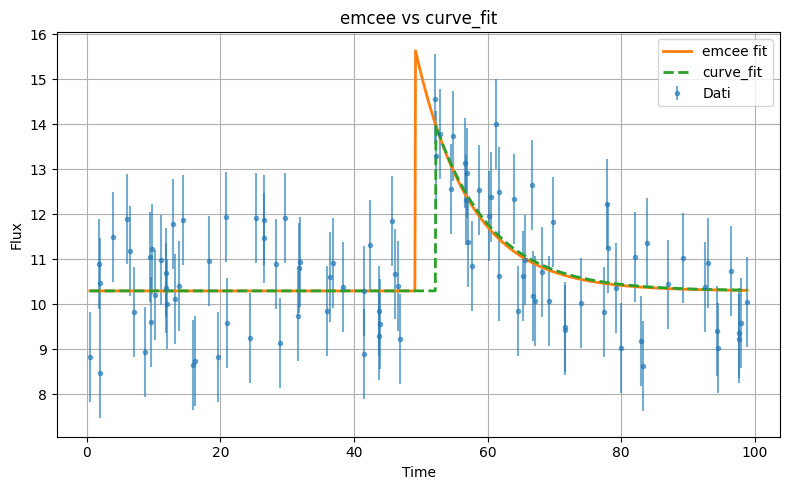

In [10]:
from scipy.optimize import curve_fit

# I want to compare the results of emcee with curve_fit

def model_curve_fit(t, C, A, alpha, t0): # problem with the array ...
    return np.where(t < t0,
                    C,
                    C + A * np.exp(-alpha * (t - t0)))

# === just to get an error on the parameter of emcee ===
samples = sampler.get_chain(flat=True)
medians = np.median(samples, axis=0)
q16, q84 = np.percentile(samples, [16, 84], axis=0)
errors_emcee = 0.5 * (q84 - q16)  # symmetric 1σ error

# emcee median
samples = sampler.get_chain(flat=True)
C_emcee, A_emcee, alpha_emcee, t0_emcee = np.median(samples, axis=0)
err_C_emcee, err_A_emcee, err_alpha_emcee, err_t0_emcee = errors_emcee

# === curve_fit ===
popt, pcov = curve_fit(model_curve_fit, time_data, flux, sigma=err, p0=[C0, A0, alpha0, t0_init])
perr = np.sqrt(np.diag(pcov))  # 1σ uncertainties from covariance
C_cf, A_cf, alpha_cf, t0_cf = popt
err_C_cf, err_A_cf, err_alpha_cf, err_t0_cf = perr

# === Comparison ===
print("\n=== Parameter comparison (with uncertainties) ===")
print(f"emcee:      C = {C_emcee:.3f} ± {err_C_emcee:.3f}")
print(f"            A = {A_emcee:.3f} ± {err_A_emcee:.3f}")
print(f"        alpha = {alpha_emcee:.3f} ± {err_alpha_emcee:.3f}")
print(f"           t0 = {t0_emcee:.3f} ± {err_t0_emcee:.3f}")

print(f"\ncurve_fit:  C = {C_cf:.3f} ± {err_C_cf:.3f}")
print(f"            A = {A_cf:.3f} ± {err_A_cf:.3f}")
print(f"        alpha = {alpha_cf:.3f} ± {err_alpha_cf:.3f}")
print(f"           t0 = {t0_cf:.3f} ± {err_t0_cf:.3f}")

# === Plot ===
t_fit = np.linspace(time_data.min(), time_data.max(), 1000)
flux_emcee = model_curve_fit(t_fit, C_emcee, A_emcee, alpha_emcee, t0_emcee)
flux_cf  = model_curve_fit(t_fit, C_cf, A_cf, alpha_cf, t0_cf)

plt.figure(figsize=(8, 5))
plt.errorbar(time_data, flux, yerr=err, fmt='.', label='Dati', alpha=0.6)
plt.plot(t_fit, flux_emcee ,'-', lw=2, label='emcee fit', c='C1')
plt.plot(t_fit, flux_cf, '--', lw=2, label='curve_fit', c='C2')
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("emcee vs curve_fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### **Different Approaches**

`curve_fit` finds a single best-fit solution by minimizing the squared residuals. It assumes Gaussian errors and symmetric uncertainties. On the other hand, `emcee` samples the full posterior distribution, naturally accounting for parameter correlations and possible asymmetries in the uncertainties.

---

### Similarities and Differences in Parameters

The estimates for the baseline level (**C**) and decay rate (**α**) are very close between the two methods. This suggests these parameters are well constrained by the data and the assumptions behind `curve_fit` are reasonable here.

However, the amplitude (**A**) and the characteristic time (**t₀**) show noticeable differences. This likely reflects a strong correlation between these two parameters, as previously seen in the tilted joint distributions from the corner plot.

---

### What Does This Mean?

While `curve_fit` identifies a local minimum of the chi-square function, it does not capture parameter correlations or degeneracies. `emcee`, by exploring the full posterior, shows that a range of $A$ and $ t_0 $ combinations fit the data well.

In other words, `emcee` gives a more complete and realistic picture of the uncertainties and parameter interdependencies, whereas `curve_fit` provides a quicker but more limited summary.




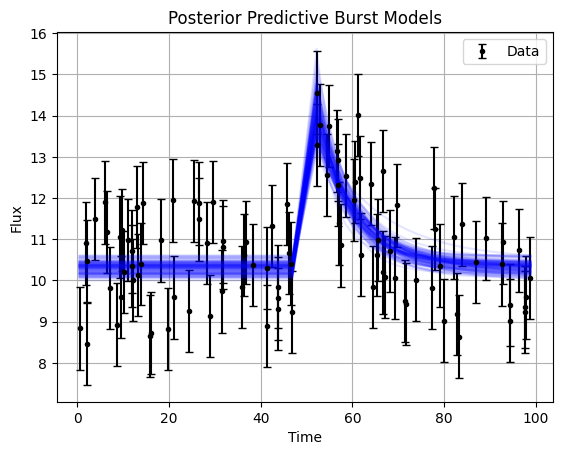

In [7]:
# Extract 100 random samples from the posterior
idx = np.random.choice(len(flat_samples), size=100, replace=False)
sample = flat_samples[idx]

# Plot data with error bars
plt.errorbar(time_data, flux, yerr=err, fmt='.', color='black', label='Data', capsize=3)

# Plot the 100 models generated from the posterior parameters
for theta in sample:
    plt.plot(time_data, model(time_data, theta), color='blue', alpha=0.1)

plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Posterior Predictive Burst Models")
plt.legend()
plt.grid(True)
plt.show()


#WHT IS THE CURVE INCLINATED???